# ADALINE を確立的勾配降下法（SGD）を使って学習させる

※ADALINE_with_Batchの一部を変更、要素の追加をすることでSGDを実現できる

In [1]:
import numpy as np
from numpy.random import seed

class AdalineSGD(object):
    """
    param:
    eta: float, 学習率
    n_iter: int, トレーニング回数
    random_state: int, 重みを初期化する乱数シード
    
    shuffle: bool(defalut True), Trueの時にトレーニングデータをシャッフルする
    
    attribute:
    w_: 1次元配列, 学習した重み
    cost_: list, 予測値と目標値を使って計算された誤差
    
    """
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.shuffle = shuffle
        # 重みの初期化フラグはFalseにしておく
        self.w_initialized = False
        
    def fit(self, X, y):
        """
        param:
        X: 訓練データ
        y: 予測値
        
        戻り値:
        self: オブジェクト
        
        """
        # 重みベクトルを生成
        self._initialize_weights(X.shape[1])
        # rgen = np.random.RandomState(self.random_state)
        # self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        
        # コストを入れるリストを定義
        self.cost_ = []
        
        # n_iter分モデルを学習（訓練）させる
        for i in range(self.n_iter):
            # 訓練データをシャッフルするかどうか
            if self.shuffle:
                X, y = self._shuffle(X, y)
            
            # 訓練データの各サンプルを使って計算されたコストを入れるリスト
            cost = []
            
            # サンプル毎に計算
            for xi, target in zip(X, y):
                # 特徴量xiと目標値yを使ってコストを計算、重みを更新→メソッドにやらせる
                cost.append(self._update_weights(xi, target))
            
            # サンプル毎に計算されたコストの平均を求める
            # avg_cost = cost.mean()
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        
        return self
    
    
    def partial_fit(self, X, y):
        """
        重みを再初期化することをせず学習を進める
        新しい訓練サンプルが来た場合のモデル学習（オンライン学習）
        """
        
        # 初期化されていない場合は初期化を実行
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
            
        # 新たに追加されたサンプルの特徴量が2要素以上（＝目標値が2要素以上）の場合
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        
        # 新たに追加されたサンプルの特徴量が1要素（＝目標値が1要素）の場合
        else:
            self._update_weights(X, y)
        
        return self
    
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m)
        self.w_initialized = True
        
        
    def _update_weights(self, xi, target):
        # 活性化関数の出力
        output = self.activation(self.net_input(xi))
        
        # 誤差の計算
        error = (target - output)
        
        # 重みΔの更新
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        
        # コストの計算
        cost = 0.5 * error ** 2
        
        return cost                
    
    
    def net_input(self, X):
        # 総入力を計算
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    
    def activation(self, X):
        return X
    
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)
            
        

In [2]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # グリッド配列を1次元にする(各特徴量を1次元配列に直してから予測を実行)
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測した結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    
    # 値の範囲
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラス毎にサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolors='black')

### ADALINE_with_SGD

In [4]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline


/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)

y = df.iloc[0:100, 4].values

y = np.where(y == 'Iris-setosa', -1, 1)

X = df.iloc[0:100, [0, 2]].values

In [7]:
# Xを標準化
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()
# X_std

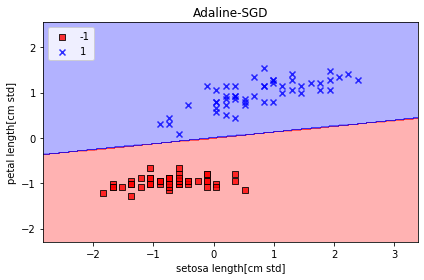

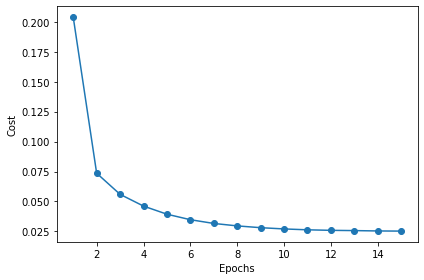

In [8]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)

plt.title('Adaline-SGD')
plt.xlabel('setosa length[cm std]')
plt.ylabel('petal length[cm std]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# epochとcostの関係もグラフで
plt.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()